<a href="https://colab.research.google.com/github/joaoschs/IBM-Data-Science-Project/blob/main/FinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import requests
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
# Step 1: Define the SpaceX API endpoint
api_url = "https://api.spacexdata.com/v4/launches"

# Step 2: Send an HTTP GET request to the API
response = requests.get(api_url)

# Check if the response is successful
if response.status_code == 200:
    print("Data retrieved successfully!")
    # Step 3: Parse the JSON response
    data = response.json()
else:
    print(f"Failed to retrieve data. HTTP Status code: {response.status_code}")
    exit()

# Step 4: Convert JSON data to a Pandas DataFrame
df = pd.json_normalize(data)



Data retrieved successfully!


In [4]:
# Preview the raw data
print("Raw data preview:")
print(df.head())

# Step 5: Select relevant columns for analysis
columns_of_interest = [
    'name',              # Mission name
    'date_utc',          # Launch date
    'success',           # Launch success (True/False)
    'rocket',            # Rocket ID
    'payloads',          # Payload ID(s)
    'launchpad',         # Launchpad ID
    'cores',             # Rocket core details
    'flight_number'      # Mission flight number
]
df = df[columns_of_interest]


Raw data preview:
       static_fire_date_utc  static_fire_date_unix    net  window  \
0  2006-03-17T00:00:00.000Z           1.142554e+09  False     0.0   
1                      None                    NaN  False     0.0   
2                      None                    NaN  False     0.0   
3  2008-09-20T00:00:00.000Z           1.221869e+09  False     0.0   
4                      None                    NaN  False     0.0   

                     rocket success  \
0  5e9d0d95eda69955f709d1eb   False   
1  5e9d0d95eda69955f709d1eb   False   
2  5e9d0d95eda69955f709d1eb   False   
3  5e9d0d95eda69955f709d1eb    True   
4  5e9d0d95eda69955f709d1eb    True   

                                            failures  \
0  [{'time': 33, 'altitude': None, 'reason': 'mer...   
1  [{'time': 301, 'altitude': 289, 'reason': 'har...   
2  [{'time': 140, 'altitude': 35, 'reason': 'resi...   
3                                                 []   
4                                                 []

In [5]:
# Step 6: Convert data types and handle nested columns
# Convert 'date_utc' to datetime format
df['date_utc'] = pd.to_datetime(df['date_utc'])

# Extract first core's landing outcome if available (nested structure in 'cores')
df['landing_success'] = df['cores'].apply(lambda x: x[0]['landing_success'] if x and isinstance(x, list) and 'landing_success' in x[0] else None)



In [6]:
# Step 7: Data Cleaning
# Replace missing values in 'success' and 'landing_success' with "Unknown"
df['success'] = df['success'].fillna("Unknown")
df['landing_success'] = df['landing_success'].fillna("Unknown")


In [7]:
# Step 8: Save the processed data locally
df.to_csv("spacex_launch_data.csv", index=False)
print("Data successfully cleaned and saved to 'spacex_launch_data.csv'.")

# Step 9: Basic Exploratory Data Analysis (EDA)
# Summary statistics
print("\nSummary of launch outcomes:")
print(df['success'].value_counts())

print("\nSummary of landing outcomes:")
print(df['landing_success'].value_counts())


Data successfully cleaned and saved to 'spacex_launch_data.csv'.

Summary of launch outcomes:
success
True       181
Unknown     19
False        5
Name: count, dtype: int64

Summary of landing outcomes:
landing_success
True       143
Unknown     49
False       13
Name: count, dtype: int64


<ipython-input-8-35c7966a8f56>:2: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  df.set_index('date_utc')['success'].resample('Y').count().plot(


<Axes: title={'center': 'Number of SpaceX Launches Over Time'}, xlabel='Year', ylabel='Number of Launches'>

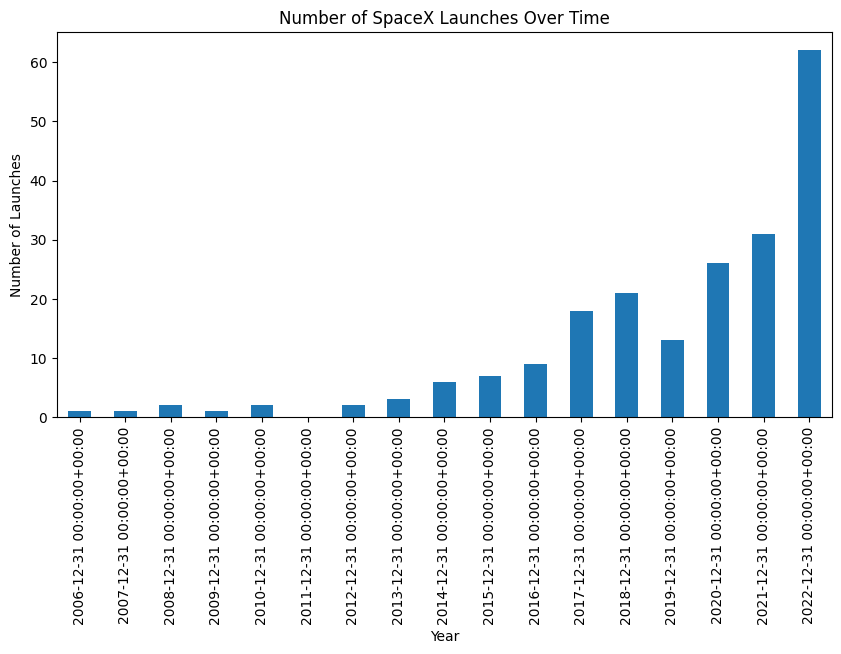

In [8]:
# Plot the number of launches over time
df.set_index('date_utc')['success'].resample('Y').count().plot(
    title='Number of SpaceX Launches Over Time',
    figsize=(10, 5),
    xlabel='Year',
    ylabel='Number of Launches',
    kind='bar'
)



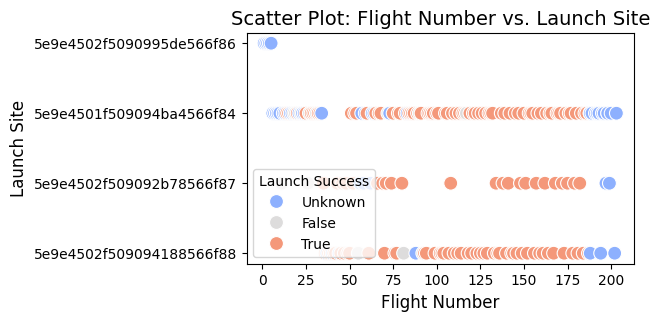

In [20]:
# Create a scatter plot
plt.figure(figsize=(5, 3))
sns.scatterplot(data=df, x='flight_number', y='launchpad', hue='landing_success', palette='coolwarm', s=100)

# Add plot title and labels
plt.title('Scatter Plot: Flight Number vs. Launch Site', fontsize=14)
plt.xlabel('Flight Number', fontsize=12)
plt.ylabel('Launch Site', fontsize=12)
plt.legend(title='Launch Success', loc='best')

# Show the plot
plt.show()

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure the 'payload_mass_kg' column exists
# Extract payload mass from nested data if 'payloads' contains lists
df['payload_mass_kg'] = df['payloads'].apply(
    lambda x: sum([p.get('payload_mass_kg', 0) for p in x]) if isinstance(x, list) else 0
)

# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(df['launchpad'], df['payload_mass_kg'], alpha=0.7, c='blue')
plt.title('Payload Mass vs. Launch Site', fontsize=14)
plt.xlabel('Launch Site', fontsize=12)
plt.ylabel('Payload Mass (kg)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(alpha=0.5)

# Show the plot
plt.tight_layout()
plt.show()

AttributeError: 'str' object has no attribute 'get'

In [27]:
import folium

# Coordinates for all SpaceX launch sites
launch_sites = {
    "CCAFS LC-40": [28.562302, -80.577356],
    "VAFB SLC-4E": [34.632834, -120.610746],
    "KSC LC-39A": [28.573255, -80.646895],
    "STLS": [25.997264, -97.156084]
}

# Create a map centered at the approximate geographic center of all sites
map_center = [30.0, -90.0]
spacex_map = folium.Map(location=map_center, zoom_start=4)

# Add markers for each launch site
for site, coords in launch_sites.items():
    folium.Marker(
        location=coords,
        popup=f"<strong>{site}</strong>",
        icon=folium.Icon(color="blue", icon="rocket"),
    ).add_to(spacex_map)

# Save map to file
spacex_map.save("spacex_launch_sites_map.html")
spacex_map


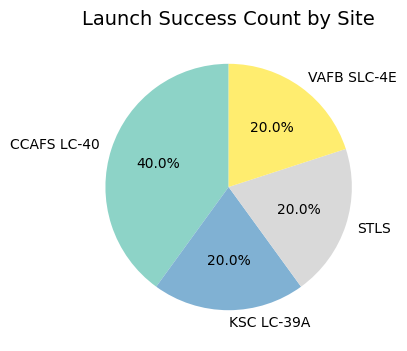

In [29]:
df = pd.DataFrame({
    'launchpad': ['CCAFS LC-40', 'VAFB SLC-4E', 'KSC LC-39A', 'STLS', 'CCAFS LC-40', 'VAFB SLC-4E'],
    'success': [1, 0, 1, 1, 1, 1]  # 1 for success, 0 for failure
})

# Calculate success counts by launchpad
launch_success_counts = df.groupby('launchpad')['success'].sum()

# Create the pie chart
plt.figure(figsize=(6, 4))
launch_success_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90, cmap='Set3')
plt.title('Launch Success Count by Site', fontsize=14)
plt.ylabel('')  # To remove the y-label
plt.show()

In [30]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Assume df is the dataframe containing your data
# Example of relevant columns: 'launchpad', 'payloads', 'rocket', 'flight_number', 'success'

# Step 1: Preprocessing

# Encode categorical variables (launchpad, rocket, payload)
label_encoder = LabelEncoder()

df['launchpad'] = label_encoder.fit_transform(df['launchpad'])
df['rocket'] = label_encoder.fit_transform(df['rocket'])

# Assuming payload is a numerical column (if not, further preprocessing is needed)
df['payloads'] = df['payloads'].apply(lambda x: sum(x) if isinstance(x, list) else 0)  # If payloads are a list of objects

# Step 2: Define features and target
X = df[['launchpad', 'payloads', 'rocket', 'flight_number']]  # Features
y = df['success']  # Target variable

# Step 3: Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Step 4: Train a Random Forest Classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Step 5: Make predictions
y_pred = model.predict(X_test)

# Step 6: Evaluate the model
print("Accuracy Score:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))


KeyError: 'rocket'

In [31]:
print(df.columns)

Index(['launchpad', 'success'], dtype='object')
